## This script saves the Average Contrast Response Function for each subject, all data is saved as a 12 x 2 array.
### [0:6,:]  = 2F1 , [6:,:] = 4F2
### [:,0] = Pre Induction EEG, [:,1] = Post Induction EEG
#### 2/5/24: Can Compute and Save: Saturation Level Adjustments, Average CRF For all Subjects, Original CRF's

In [25]:
# load packages
import numpy as np 
import h5py
import scipy.io
from scipy.io   import  loadmat
import pandas as pd
import os
import matplotlib.pyplot as plt #import matplotlib as plt
from scipy.optimize import curve_fit 
import seaborn as sns #import mat73
import pickle as pkl
from datetime import datetime

### Set Dir Path(s): MainDir, SaveDataDir, SaveImgDir (Not one in this script ...)

In [26]:
# Main Directory of processed file from MatLab
MainDir = 'D:\\AttnXV3_analysis\\RCA_F1\\RCA\\' # set dir
os.chdir(MainDir) # change old dir, to this dir
d = os.listdir(MainDir) # list files in dir
##############################################
FileN = (d[0]) # choose one                         
file_path = os.path.join(MainDir, FileN) # join paths and prep 2 load
print('Current WD:',file_path) # does path exist ... ?
print('Does Path Exist?',os.path.exists(file_path)) # yes or no

Current WD: D:\AttnXV3_analysis\RCA_F1\RCA\rcaResults_Sweep_contrast_sweeps.mat
Does Path Exist? True


In [27]:
# Save Data Dir ...
SaveDataDir = 'D:\\AttnXV3_analysis\\RCA_F1\\AvgCRFs\\' # set dir where files (.pkl, .csv) will be saved
FileOutName = 'F1AverageCRF' # make sure this file changes each time you save
######################################################
dnt = datetime.now() # add date and time bc im wreckless when saving ..
fdnt = dnt.strftime("%Y%m%d_%H%M%S") # set the above as a string ...
FileN = f'{FileOutName}_{fdnt}.pkl' 
FileNToMatlab = f'{FileOutName}_{fdnt}.h5' 
#FileN = f'{FileOutName}_{fdnt}.csv' 
NewFileNPath = os.path.join(SaveDataDir,FileN)
MatLabFilePath = os.path.join(SaveDataDir, FileNToMatlab)
print('Full New File Dir: ', NewFileNPath)
print('Full New File Dir: ', MatLabFilePath)


Full New File Dir:  D:\AttnXV3_analysis\RCA_F1\AvgCRFs\F1AverageCRF_20240207_124816.pkl
Full New File Dir:  D:\AttnXV3_analysis\RCA_F1\AvgCRFs\F1AverageCRF_20240207_124816.h5


### Set Some Basic Struct Params

In [28]:
NumBins = 6 # number of contrasts
NumHarms = 2 # number of harmonic data: 2F1, 4F1
NumComp = 0 # first component from RCA
contrast_levels=np.array([1, 3, 5, 16, 40, 100])
contrast_levels_labs=['1%', '3%', '5%', '16%', '40%', '100%']

### Some Functions

In [29]:
def CleanRCA(x): # replace 0's in data with nan's
    x[x == 0] = np.nan
    return x
################################################################################
# comine real and imaginary numbers, only 1st component - For average across pre and post
def CombineRealImg(x, NumHarms):
    [NumCols, NumTrials] = np.shape(x) # 24 x 78-80
    DomainCutoff = int(NumCols/NumHarms) # use to index cutoff  - float -> int
    CondCutoff = int(NumTrials/2) # 39 - 40 depends...
    pre = x[:,:CondCutoff] # 24 x 39 - 40 depends ...
    post = x[:,CondCutoff:]
    AmpPerBin = np.ones((DomainCutoff,NumHarms)) # [bins (2f1 then 4f1)] X [pre /post] \ 12 x 2
    for RowInd in range(DomainCutoff):
        ################ combining data generated from real and imaginary comp (1st half of cols and last half)
        AmpPerBin[RowInd,0] = np.hypot(np.nanmean(pre[RowInd,:]),np.nanmean(pre[RowInd+DomainCutoff,:])) # 12 x 78 PRE
        AmpPerBin[RowInd,1] = np.hypot(np.nanmean(post[RowInd,:]),np.nanmean(post[RowInd+DomainCutoff,:])) # 12 x 78 POST
    return AmpPerBin # single array output
###########################################################################################################################
def FixSaturation(x,NumBins,NumSubs,start,end,col):
    r1 = start
    r2 = end
    cond = col 
    d = np.zeros((NumSubs,NumBins))
    pos_rec = []
    for i in range(NumSubs):
        dataIn = x[i][r1:r2,cond] 
        dataOut = np.zeros((1,NumBins))
        maxpos = np.argmax(dataIn, axis = 0)
        pos_rec.append(maxpos)
        maxamp = dataIn[maxpos]
        if maxpos < NumBins:
            dataOut[0,:maxpos] =  dataIn[:maxpos]
            dataOut[0,maxpos:] = maxamp
            d[i,:] = dataOut
        else:
            d[i,:]  = dataIn
    return d, pos_rec

### Load Data

In [30]:
mat_data = scipy.io.loadmat(file_path)
rca = mat_data['rcaResult']['projectedData'][0,0]
rcaData = [rca[i,0] for i in range(rca.shape[0])] # final data output

#### Load Subj Names (later: and Create an Index for left and right)

In [31]:
# load subject names 
SubNames = mat_data['rcaResult'][0,0][5]
FileName = [x[0][3:] for subjlist in SubNames for x in subjlist[0][2][0]]
print(len(FileName))
print(FileName[0])

55
2651_attnL_20231003_1500


### Set 0's to NaN's

In [32]:
data = dict()
for k in range(len(rcaData)):
    data[k] = CleanRCA(rcaData[k])
NumSubs = int(len(data.keys()))

### Combine Real and Imaginary Numbers on Average for Each Data File

## Save Option #1 - Original Contrast Response Functions : avgCRF

In [33]:
avgCRF = dict()
for i in range(NumSubs):
    dataIn = data[i][:,NumComp,:] # only for 1st rca component
    avgCRF[i] = CombineRealImg(dataIn,NumHarms)

## Save Option #2 - Fix Super/Saturation that Occurs Near the High Contrasts : avgCRF_1

In [34]:
pre1, pr1 = FixSaturation(avgCRF,NumBins,NumSubs,0,6,0) # [55 x 6] ~ [NumSubs x Contrast]
post1, pr2 = FixSaturation(avgCRF,NumBins,NumSubs,0,6,1) 
pre2, pr3 = FixSaturation(avgCRF,NumBins,NumSubs,6,12,0)
post2, pr4 = FixSaturation(avgCRF,NumBins,NumSubs,6,12,1)

In [35]:
p1 = np.array(pr1)
print(np.unique(contrast_levels[p1],return_counts = True))

(array([  3,   5,  16,  40, 100]), array([ 1,  5, 14, 17, 18], dtype=int64))


#### Visual for Confirmation

Text(0.5, 1.0, 'Post 4F')

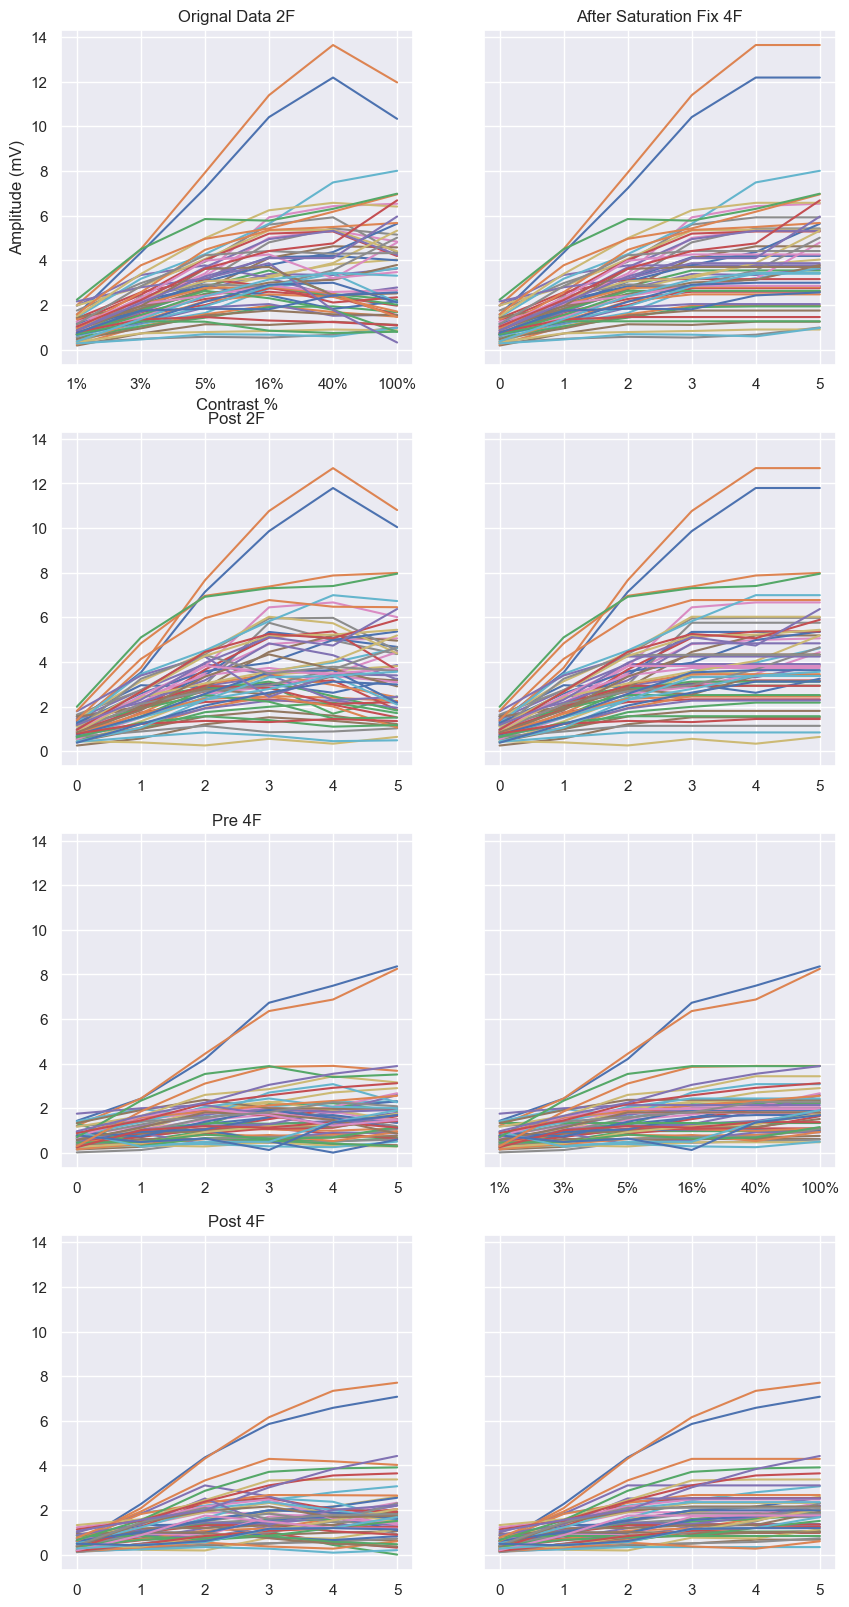

In [36]:
# visual of how data looks uncorrected / corrected
sns.set_theme()
fig, axs = plt.subplots(4,2,figsize = (10,20), sharey = True, sharex = False)
for i in range(NumSubs):
    axs[0,0].plot(avgCRF[i][0:6,0]) # pre 2f
    axs[0,0].set_xticks(range(len(contrast_levels_labs)))
    axs[0,0].set_xticklabels(contrast_levels_labs)

    axs[1,0].plot(avgCRF[i][0:6,1]) #post 2f
    axs[2,0].plot(avgCRF[i][6:,0]) # pre 4f
    axs[3,0].plot(avgCRF[i][6:,1]) # post 4f
    axs[0,1].plot(pre1[i,:])
    axs[1,1].plot(post1[i,:])
    axs[2,1].plot(pre2[i,:])
    axs[2,1].set_xticks(range(len(contrast_levels_labs)))
    axs[2,1].set_xticklabels(contrast_levels_labs)
    axs[3,1].plot(post2[i,:])

axs[0,0].set_title('Orignal Data 2F')
axs[0,0].set_xlabel('Contrast %')
axs[0,0].set_ylabel('Amplitude (mV)')
axs[0,1].set_title('After Saturation Fix 4F')

axs[1,0].set_title('Post 2F')
axs[2,0].set_title('Pre 4F')
axs[3,0].set_title('Post 4F')

#### Save Data in the Format Other Scripts are Designed to Handle

In [37]:
avgCRF_1 = dict() # NumSubjs worth of keys()
for ind in range(NumSubs):
    apb = np.zeros((NumBins*2,NumHarms))  # [12x2] array
    apb[:6,0] = pre1[ind,:]
    apb[6:,0] = pre2[ind,:]
    apb[:6,1] = post1[ind,:]
    apb[6:,1] = post2[ind,:]
    avgCRF_1[ind] = apb
    #print(avgCRF[ind].shape) # [12 x 2]
if (len(avgCRF_1.keys()) == NumSubs):
    print(f'All {NumSubs} Subjects CRF Data Saved! :))')

All 55 Subjects CRF Data Saved! :))


## Save Option #3 - Contrast Response Function Averaged - 12 x 2 array only

In [38]:
all_subjavgCRF = np.zeros((12,2))
m1 = np.zeros((NumSubs,1))
m2 = np.zeros((NumSubs,1))
for bin in range(NumBins*2): # 6
    for j in range(NumSubs): # 55
        r1 = avgCRF[j][bin,0]
        r2 = avgCRF[j][bin,1]
        m1[j,0] = r1
        m2[j,0] = r2
    
        avgcrf1 = np.mean(m1, axis = 0)
        avgcrf2 = np.mean(m2, axis = 0)
    all_subjavgCRF[bin,0] = avgcrf1
    all_subjavgCRF[bin,1] = avgcrf2
#print(all_subjavgCRF)
print(f'All CRFs have been averaged! A {np.shape(all_subjavgCRF)} array is avilable to export')

All CRFs have been averaged! A (12, 2) array is avilable to export


## Save Option #4 - NO SATURATION Contrast Response Function Averaged - 12 x 2 array only

In [39]:
all_subjavgCRF_NoSat = np.zeros((12,2))
m1 = np.zeros((NumSubs,1))
m2 = np.zeros((NumSubs,1))
for bin in range(NumBins*2): # 6
    for j in range(NumSubs): # 55
        r1 = avgCRF_1[j][bin,0]
        r2 = avgCRF_1[j][bin,1]
        m1[j,0] = r1
        m2[j,0] = r2
    
        avgcrf1 = np.mean(m1, axis = 0)
        avgcrf2 = np.mean(m2, axis = 0)
    all_subjavgCRF_NoSat[bin,0] = avgcrf1
    all_subjavgCRF_NoSat[bin,1] = avgcrf2
#print(all_subjavgCRF)
print(f'All CRFs have been averaged! A {np.shape(all_subjavgCRF_NoSat)} array is avilable to export')

All CRFs have been averaged! A (12, 2) array is avilable to export


In [40]:
print(all_subjavgCRF_NoSat[0:6,0] == all_subjavgCRF[0:6,0])
# just check if data is false as higher contrasts progress .. 

[ True  True False False False False]


#### Quick Viz of avg crf

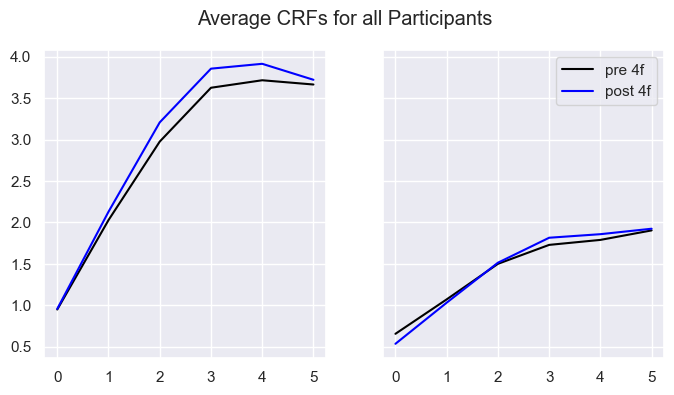

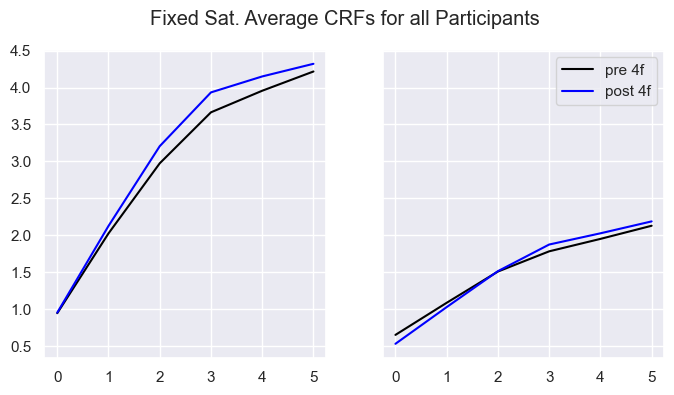

In [41]:
fig,axs = plt.subplots(1,2, figsize=(8,4), sharey=True)
axs[0].plot(all_subjavgCRF[:6,0], color = 'black', label = 'pre 2f')
axs[0].plot(all_subjavgCRF[:6,1], color = 'blue', label = 'post 2f')
axs[1].plot(all_subjavgCRF[6:,0], color = 'black', label = 'pre 4f')
axs[1].plot(all_subjavgCRF[6:,1], color = 'blue', label = 'post 4f')
plt.suptitle('Average CRFs for all Participants')
plt.legend()
plt.show()

fig,axs = plt.subplots(1,2, figsize=(8,4), sharey=True)
axs[0].plot(all_subjavgCRF_NoSat[:6,0], color = 'black', label = 'pre 2f')
axs[0].plot(all_subjavgCRF_NoSat[:6,1], color = 'blue', label = 'post 2f')
axs[1].plot(all_subjavgCRF_NoSat[6:,0], color = 'black', label = 'pre 4f')
axs[1].plot(all_subjavgCRF_NoSat[6:,1], color = 'blue', label = 'post 4f')
plt.suptitle('Fixed Sat. Average CRFs for all Participants')
plt.legend()
plt.show()

### Save Data! Choose One Array or Export All Data

In [42]:
ExportDataToFile = 'y' # dont gotta explain this one ...
# all data into a single dict to export
allData = {'OriginalCRF':avgCRF, # all crf's
           'NoSatCRF'   :avgCRF_1, # fixed saturation crf's
           'avgCRF'     :all_subjavgCRF, # single crf for all data files
           'NoSatavgCRF':all_subjavgCRF_NoSat,
           'FileNames'  :FileName} # single crf for all data files - super/saturation fixed

# A few manners and options to save data
if ExportDataToFile == 'y':
    # 1: Save only 1 array of data 1 dict only .............
    #pkl.dump(avgCRF, open(NewFileNPath,'wb')) # Orginal Uncorrected CRF's
    #pkl.dump(avgCRF_1, open(NewFileNPath,'wb')) # Modified for Saturation

    # 2: Save data as a csv file  1 dict only....................
    #tpdta = list(zip(*avgCRF.values()))
    #df = pd.DataFrame(tpdta, columns=avgCRF.keys())
    #df.to_csv(NewFileNPath, index = False)

    # 3: Save Mass Subj CRF as an Array ####
    #df = pd.DataFrame(all_subjavgCRF)
    #df.to_csv(NewFileNPath, index=False)

    # 4: Save all the Data, original, corrected and averaged
    #with h5py.File(MatLabFilePath, 'w') as hf:
    #    for key, value in allData.items():
    #        hf.create_dataset(key, data=value)

    with open(NewFileNPath, 'wb') as file:
        pkl.dump(allData, file)
    print('Average CRF Saved! :))')
else:
    print('Did Not Save File! Change file name before switching to y!')

Average CRF Saved! :))


#### For Later

In [43]:
##### Future Goals...!: 
##### 1.: Import Noise1 and Noise2 and compute that as the first level of contrast

#NoiseLow = mat_data['rcaResult']['noiseData'][0,0][0,0][0]
#nl = [NoiseLow[i,0] for i in range(NoiseLow.shape[0])]

#NoiseHigh = mat_data['rcaResult']['noiseData'][0,0][0,0][1]
#nh = [NoiseHigh[i,0] for i in range(NoiseHigh.shape[0])]